In [13]:
import os
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import tensorflow as tf
import keras
from keras import models
from keras import layers
from keras import optimizers
import statistics

%matplotlib inline
print(tf.__version__)

2.10.1


Number of images: 1660
Mean: 94.04939759036145
Geometric mean: 84.72840301601072
Median: 76.0
Min: 49
Max: 514


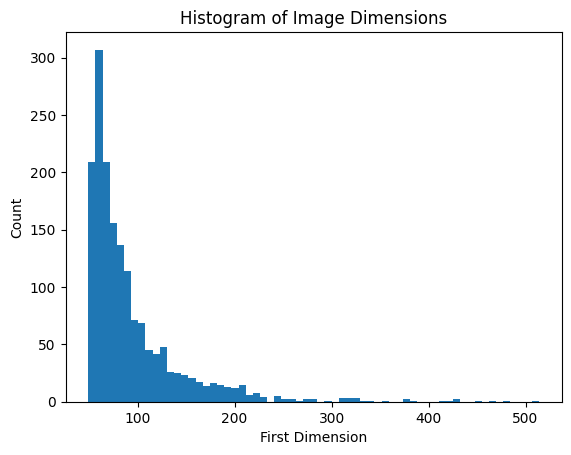

In [28]:
dataset = "../mldataset/cropped"
dirs = [os.path.join(dataset, "ConfirmedFiles"),
        os.path.join(dataset, "RejectedFiles")]
dimensions = []

for i in dirs:
    for j in os.listdir(i):

        imgs = os.path.join(i, j, "images")
        if not os.path.exists(imgs):
            continue
        for img in os.listdir(imgs):

            img = os.path.join(imgs, img)

            img = Image.open(img)
            img_array = np.array(img)
            dimensions.append(img_array.shape[0])
            img_array = np.expand_dims(img_array, axis=-1)

print("Number of images:", len(dimensions))
print("Mean:", np.mean(dimensions))
print("Geometric mean:", statistics.geometric_mean(dimensions))
print("Median:", np.median(dimensions))
print("Min:", np.min(dimensions))
print("Max:", np.max(dimensions))

plt.hist(dimensions, bins="auto")

plt.xlabel("First Dimension")
plt.ylabel("Count")
plt.title("Histogram of Image Dimensions")
plt.show()

In [29]:
confirmed_num = 0
for subfolder in os.listdir(dirs[0]):
    imgs = os.path.join(dirs[0], subfolder, "images")
    confirmed_num += len(os.listdir(imgs))
print("Number of confirmed images:", confirmed_num)

rejected_images = []
rejected_num = 0
for subfolder in os.listdir(dirs[1]):
    if not os.path.exists(os.path.join(dirs[1], subfolder, "images")):
        continue
    imgs = os.path.join(dirs[1], subfolder, "images")
    rejected_images += [os.path.join(imgs, filename) for filename in os.listdir(imgs)]
    rejected_num += len(os.listdir(imgs))
print("Number of rejected images:", rejected_num)

Number of confirmed images: 830
Number of rejected images: 830


In [16]:
data_augmentation = tf.keras.Sequential(
    [
        layers.RandomFlip("horizontal_and_vertical"),
        layers.RandomRotation(0.2),
    ]
)

# balance classes by using data augmentation
while rejected_num < confirmed_num:
    random_image = tf.random.shuffle(rejected_images)[0]
    random_image_path = random_image.numpy().decode("utf-8")
    img = Image.open(random_image_path)
    img_array = np.array(img)
    img_array = np.expand_dims(img_array, axis=-1)

    img_array = data_augmentation(img_array)


    augmented_img = Image.fromarray(np.squeeze(img_array).astype(np.uint8))
    os.makedirs(os.path.join(dirs[1], "synthesized", "images"), exist_ok=True)
    # Save the image
    base_filename = os.path.basename(random_image_path)[:-4] + "_augmented"
    full_path = os.path.join(dirs[1], "synthesized", "images", base_filename + ".png")
    i = 1

    # Loop until we find a filename that does not already exist
    while os.path.exists(full_path):
        # If a file with the same name already exists, append the counter to the filename
        full_path = os.path.join(
            dirs[1], "synthesized", "images", base_filename + "_" + str(i) + ".png"
        )
        # Increment the counter
        i += 1
    augmented_img.save(full_path)
    rejected_num += 1
print("Classes balanced.")
print("Number of confirmed images:", confirmed_num)
print("Number of rejected images:", rejected_num)

Classes balanced.
Number of confirmed images: 830
Number of rejected images: 830


In [17]:
IMG_SIZE = 83
BATCH_SIZE = 32
train_ds, val_ds = tf.keras.utils.image_dataset_from_directory(
    dataset,
    label_mode="binary",
    color_mode="grayscale",
    batch_size=BATCH_SIZE,
    validation_split=0.3,
    subset="both",
    seed=123,
    image_size=(IMG_SIZE, IMG_SIZE),
)
class_names = train_ds.class_names

AUTOTUNE = tf.data.AUTOTUNE

Found 1660 files belonging to 2 classes.
Using 1162 files for training.
Using 498 files for validation.


In [18]:
def standardize_image(image, label):
    image = tf.image.per_image_standardization(image)
    return image, label

# standardize each image to have mean 0 and variance 1
train_ds = train_ds.map(standardize_image, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(standardize_image, num_parallel_calls=AUTOTUNE)

# buffered prefetching
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

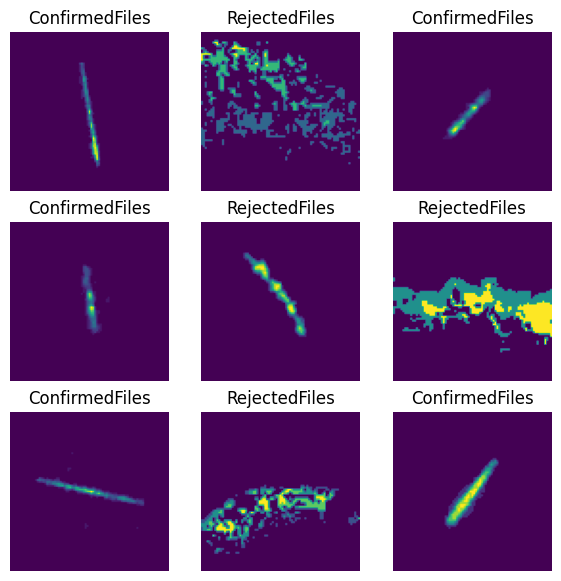

In [19]:
# visualization
plt.figure(figsize=(7, 7))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        img = images[i].numpy().astype("uint8")
        plt.imshow(img)
        plt.title(class_names[int(labels[i])])
        plt.axis("off")

In [30]:
# model from https://github.com/fiachraf/meteorml/blob/main/keras/training_scripts/CNN_script_20220325_1.py#L133

model = models.Sequential()

# added by me, so that these normalization steps arent done before the model
model.add(layers.Resizing(IMG_SIZE, IMG_SIZE))
model.add(layers.Rescaling(1.0 / 255))

model.add(layers.Conv2D(8, (5, 5), activation="relu"))
model.add(layers.MaxPooling2D((5, 5)))
model.add(layers.Flatten())
model.add(layers.Dense(16, activation="relu"))
model.add(layers.Dense(1, activation="sigmoid"))

model.build((BATCH_SIZE, 83, 83, 1))

model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing_6 (Resizing)       (32, 83, 83, 1)           0         
                                                                 
 rescaling_6 (Rescaling)     (32, 83, 83, 1)           0         
                                                                 
 conv2d_6 (Conv2D)           (32, 79, 79, 8)           208       
                                                                 
 max_pooling2d_6 (MaxPooling  (32, 15, 15, 8)          0         
 2D)                                                             
                                                                 
 flatten_6 (Flatten)         (32, 1800)                0         
                                                                 
 dense_9 (Dense)             (32, 16)                  28816     
                                                      

In [31]:
model.compile(loss="binary_crossentropy",
              optimizer=optimizers.Adam(), metrics=["acc"])

In [32]:
history = model.fit(
    train_ds,
    epochs=10,
    validation_data=val_ds,
)

Epoch 1/10


37/37 [==============================] - 1s 12ms/step - loss: 0.6730 - acc: 0.7272 - val_loss: 0.6272 - val_acc: 0.8574
Epoch 2/10
37/37 [==============================] - 0s 5ms/step - loss: 0.5433 - acc: 0.8726 - val_loss: 0.4173 - val_acc: 0.9418
Epoch 3/10
37/37 [==============================] - 0s 5ms/step - loss: 0.3170 - acc: 0.9406 - val_loss: 0.2240 - val_acc: 0.9498
Epoch 4/10
37/37 [==============================] - 0s 5ms/step - loss: 0.1949 - acc: 0.9406 - val_loss: 0.1684 - val_acc: 0.9518
Epoch 5/10
37/37 [==============================] - 0s 5ms/step - loss: 0.1492 - acc: 0.9449 - val_loss: 0.1418 - val_acc: 0.9498
Epoch 6/10
37/37 [==============================] - 0s 5ms/step - loss: 0.1370 - acc: 0.9484 - val_loss: 0.1342 - val_acc: 0.9518
Epoch 7/10
37/37 [==============================] - 0s 5ms/step - loss: 0.1275 - acc: 0.9492 - val_loss: 0.1387 - val_acc: 0.9538
Epoch 8/10
37/37 [==============================] - 0s 5ms/step - loss: 0.1212 - acc: 0.9552 - val_l